In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.ts_utils import * 
from scripts.python.tsmodel import * 

import warnings
warnings.filterwarnings('ignore')

In [2]:
folder = os.getcwd() + "/data/tourism/tonga/intermediate/"
filepath = [folder + file for file in os.listdir(folder) if ".csv" in file]

## Load and Merge

In [3]:
tonga = pd.read_csv(filepath[0]).drop("Unnamed: 0", axis=1)
tonga.groupby(by="Year").count()

,Air,Ship,Yacht,Total,date
Year,,,,,
2010,12,12,12,12,12
2011,12,11,12,12,12
2012,12,12,12,12,12
2013,12,12,12,12,12
2014,12,12,12,12,12
2015,12,12,12,12,12
2016,12,12,12,12,12
2017,12,12,12,12,12
2018,12,12,12,12,12


In [4]:
from scripts.python.PdfParse import check_quality
idxes = check_quality(tonga, ["date", "Year"], "Total")
for idx in idxes:
    combined_strs = str(tonga.iloc[idx, 1]) + str(tonga.iloc[idx, 2])
    combined_num = float(combined_strs)
    if combined_num == float(tonga["Total"][idx]):
        tonga.iloc[idx, 1], tonga.iloc[idx, 2] = combined_num, 0

In [5]:
tonga = (tonga.drop_duplicates().reset_index().drop("index", axis=1))
tonga["date"] = pd.to_datetime(tonga["date"] )
tonga.groupby(by="Year").count()

,Air,Ship,Yacht,Total,date
Year,,,,,
2010,12,12,12,12,12
2011,12,11,12,12,12
2012,12,12,12,12,12
2013,12,12,12,12,12
2014,12,12,12,12,12
2015,12,12,12,12,12
2016,12,12,12,12,12
2017,12,12,12,12,12
2018,12,12,12,12,12


### Covid

In [6]:
oceania_ci = (pd.read_csv(os.getcwd() + "/data/tourism/oceania_covid_stringency.csv")
                .drop("Unnamed: 0", axis=1))
oceania_ci["date"] = pd.to_datetime(oceania_ci["date"])
oceania_ci.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [7]:
tonga = (tonga.merge(oceania_ci, how="left", on="date")
              .drop(["year", "month"], axis=1)
              .rename({"stringency_index": "covid"}, axis=1)
              .fillna(0))
tonga

,Year,Air,Ship,Yacht,Total,date,covid
0,2010,3158,646.0,4.0,3808,2010-01-01,0.000000
1,2010,2379,0.0,5.0,2384,2010-02-01,0.000000
2,2010,3134,853.0,5.0,3992,2010-03-01,0.000000
3,2010,2818,2802.0,30.0,5650,2010-04-01,0.000000
4,2010,3670,5303.0,177.0,9150,2010-05-01,0.000000
...,...,...,...,...,...,...,...
139,2021,14,0.0,0.0,14,2021-08-01,50.727782
140,2021,4,0.0,0.0,4,2021-09-01,53.614417
141,2021,8,0.0,0.0,8,2021-10-01,52.584032
142,2021,0,0.0,0.0,0,2021-11-01,53.116083


In [12]:
get_adf_df(tonga.diff().dropna(), ["Total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-3.967867,0.001588,9.0,133.0,-3.4805,-2.883528,-2.578496


training size : 133, testing size : 11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2477.877, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2482.556, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2411.202, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2480.566, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2410.309, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2411.416, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2406.961, Time=0.20 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2406.257, Time=0.43 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2410.777, Time=0.20 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2404.464, Time=0.42 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2411.712, Time=0.17 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2464.403, Time

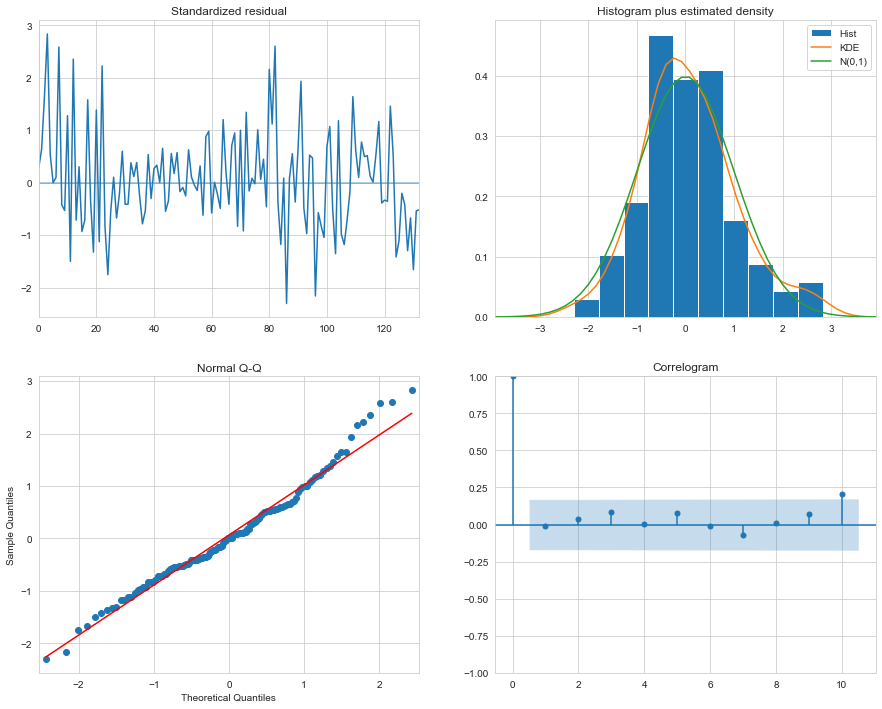

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [10]:
tg = SARIMAXPipeline(data=tonga, y_var="Total", transform_method=None,
                     exog_var="covid", training_ratio=0.925)
tg.transform()
tg.stepwise_search()

In [15]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

tg_msres = tg.manual_search(params=all_param)
tg_msres.sort(key=lambda x: x[1])

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:2702.97
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:2597.66
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:2582.65
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:2215.8
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:2190.07
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:2192.05
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:2459.79
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:2497.81
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:2513.49
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:2198.47
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:2192.06
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:2188.9
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:2437.81
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:2466.29
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:2506.43
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:2188.18
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:2190.22
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:2189.0
Tried out SAR

Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:2387.13
Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:2384.32
Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:2386.17
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:2192.48
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:2176.14
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:2176.62
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:2388.32
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:2385.48
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:2388.17
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:2173.71
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:2176.93
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:2177.51
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:2391.24
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:2392.34
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:2392.67
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:2240.64
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:2168.48
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:2169.19
Tried out 

Tried out SARIMAX(2, 1, 1)x(2, 0, 0, 12) - AIC:2368.16
Tried out SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC:2366.79
Tried out SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:2367.55
Tried out SARIMAX(2, 1, 1)x(2, 1, 0, 12) - AIC:2161.18
Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:2172.15
Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:2172.22
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:2371.02
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:2369.74
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:2371.83
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:2210.59
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:2161.81
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:2168.5
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:2367.22
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:2367.15
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:2368.17
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:2184.88
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:2169.1
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:2168.63
Tried out SA

In [17]:
tg_models = []
tg_sw = tg.stepwise_model
tg_models.append(pm.ARIMA(
    tg_sw["order"], tg_sw["seasonal_order"],  exog=tg.exog[:tg.training_size]))
for res in tg_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=tg.exog[:tg.training_size])
    tg_models.append(model)

tg_comp = tg.compare_models(
    y=tg.transformed_y[:tg.training_size],
    exog=tg.exog[:tg.training_size],
    models=tg_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [28]:
best_original = tg_msres[1][0]
original_mod = tg.get_prediction_df(best_original, steps=tg.test_size, exog=tg.exog[-tg.test_size:])
original_mod.columns.name = None
original_mod = pd.concat([tonga[["date", "Total"]], original_mod], axis=1)
original_mod.head(5)

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2010-01-01,3808,0.000000,3459.984600,-6781.445202,6781.445202,NaN
1,2010-02-01,2384,1997.229881,2874.810966,-3637.296075,7631.755837,NaN
2,2010-03-01,3992,2439.716190,2751.552705,-2953.228013,7832.660393,NaN
3,2010-04-01,5650,2931.494360,2721.245490,-2402.048793,8265.037513,NaN
4,2010-05-01,9150,3954.170376,2713.098191,-1363.404364,9271.745117,NaN


Text(0.5, 1.0, "Tonga's Visitor Arrivals")

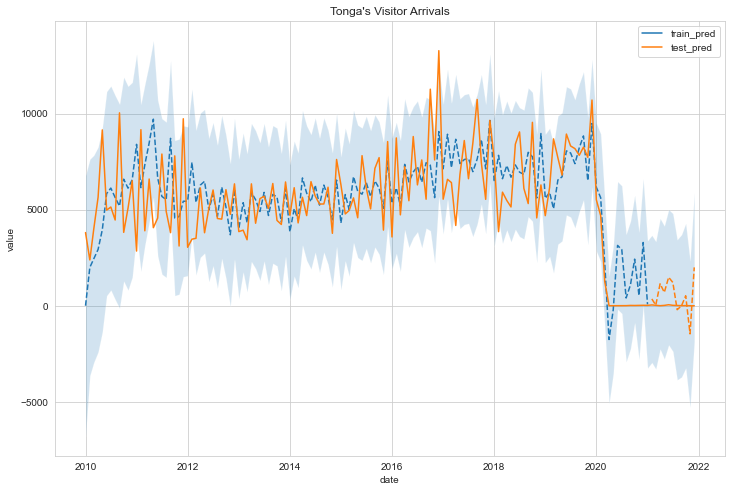

In [31]:
original_viz_df = original_mod[["date", "train_pred", "test_pred"]].melt(id_vars=["date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="date", y1="mean_ci_lower", y2="mean_ci_upper", data=original_mod, alpha=0.2)
sns.lineplot(data=original_viz_df, x="date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=original_mod, x="date", y="Total")
plt.title("Tonga's Visitor Arrivals")